In [1]:
!pip install numpy pandas

In [2]:
!pip install scikit-learn==1.4.2 imbalanced-learn==0.12.2

In [7]:
!pip install xgboost 

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
    --------------------------------------- 1.6/72.0 MB 10.5 MB/s eta 0:00:07
   -- ------------------------------------- 4.5/72.0 MB 13.4 MB/s eta 0:00:06
   ---- ----------------------------------- 7.3/72.0 MB 13.3 MB/s eta 0:00:05
   ----- ---------------------------------- 10.5/72.0 MB 13.9 MB/s eta 0:00:05
   ------- -------------------------------- 13.6/72.0 MB 14.0 MB/s eta 0:00:05
   --------- ------------------------------ 16.3/72.0 MB 13.8 MB/s eta 0:00:05
   ---------- ----------------------------- 18.9/72.0 MB 13.7 MB/s eta 0:00:04
   ------------ --------------------------- 22.0/72.0 MB 13.8 MB/s eta 0:00:04
   ------------- -------------------------- 24.9/72.0 MB 13.8 MB/s eta 0:00:04
   --------------- ------------------------ 27.8/72.0 MB 13.9 MB/s eta 0:00:04
   ---------------- ----------------------- 30.4/72.0 MB 13.7 MB/s eta 0:00:04
   ------------------ --------------------- 33.3/72.0 MB 13.7 MB

In [8]:
# Import des librairies principales
import pandas as pd
import numpy as np

# Séparation train/test
from sklearn.model_selection import train_test_split

# Métriques d'évaluation
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score,
    precision_score, balanced_accuracy_score,
    matthews_corrcoef, classification_report
)

# Modèle XGBoost
from xgboost import XGBClassifier
import xgboost as xgb




In [9]:
# Chargement du fichier CSV
df = pd.read_csv("transactions.csv")

In [10]:
df.head()

,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,promo_used,avs_match,cvv_result,three_ds_flag,transaction_time,shipping_distance_km,is_fraud
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,0,1,1,1,2024-01-06T04:09:39Z,370.95,0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,0,0,0,0,2024-01-09T20:13:47Z,149.62,0
2,3,1,141,47,147.93,92.36,FR,FR,app,travel,1,1,1,1,2024-01-12T06:20:11Z,164.08,0
3,4,1,141,47,147.93,112.47,FR,FR,web,fashion,0,1,1,1,2024-01-15T17:00:04Z,397.40,0
4,5,1,141,47,147.93,132.91,FR,US,web,electronics,0,1,1,1,2024-01-17T01:27:31Z,935.28,0


In [11]:
# Convertir la colonne en datetime avec gestion du fuseau horaire
# Pandas détecte le 'Z' et met la colonne en UTC
df["transaction_time"] = pd.to_datetime(df["transaction_time"], utc=True) #transformation de la colonne transaction_time en datetime pour avoir le moment exact de chaque transaction #

In [13]:
import pandas as pd

# Mapping des fuseaux horaires IANA pour les pays du dataset
TZ_MAP = {
    'FR': 'Europe/Paris',
    'US': 'America/New_York',
    'TR': 'Europe/Istanbul',
    'PL': 'Europe/Warsaw',
    'ES': 'Europe/Madrid',
    'IT': 'Europe/Rome',
    'RO': 'Europe/Bucharest',
    'GB': 'Europe/London',
    'NL': 'Europe/Amsterdam',
    'DE': 'Europe/Berlin'
}

# 1. Charger le dataset (Assurez-vous que cette étape est effectuée en amont)
# df = pd.read_csv("transactions.csv")

# 2. Préparation : Convertir l'heure en datetime et s'assurer qu'elle est localisée en UTC.
df["transaction_time"] = pd.to_datetime(df["transaction_time"], utc=True)

# 3. Fonction d'extraction et de conversion
def get_local_feature(row, feature_type):
    """Convertit l'horodatage UTC en local et extrait une feature spécifique."""
    country_code = row['country']
    tz_name = TZ_MAP.get(country_code, 'UTC') # Sécurité : utilise UTC si le pays n'est pas mappé
    
    # Convertir l'horodatage UTC au fuseau horaire local
    local_dt = row['transaction_time'].tz_convert(tz_name)
    
    # Extraire la feature
    if feature_type == 'hour':
        return local_dt.hour
    elif feature_type == 'dayofweek':
        return local_dt.dayofweek
    elif feature_type == 'day_name':
        return local_dt.day_name()
    elif feature_type == 'month':
        return local_dt.month
    elif feature_type == 'year':
        return local_dt.year
    elif feature_type == 'day':
        return local_dt.day
    # Retourner l'objet datetime local complet (utile pour la vérification)
    elif feature_type == 'full_local':
        return local_dt

# 4. Extraction des features locales dans le DataFrame :
df["hour_local"] = df.apply(lambda row: get_local_feature(row, 'hour'), axis=1)
df["dayofweek_local"] = df.apply(lambda row: get_local_feature(row, 'dayofweek'), axis=1)
# df["month_local"] = df.apply(lambda row: get_local_feature(row, 'month'), axis=1)
# df["year_local"] = df.apply(lambda row: get_local_feature(row, 'year'), axis=1)
df["day_local"] = df.apply(lambda row: get_local_feature(row, 'day'), axis=1)

In [14]:
print(df.columns)

Index(['transaction_id', 'user_id', 'account_age_days',
       'total_transactions_user', 'avg_amount_user', 'amount', 'country',
       'bin_country', 'channel', 'merchant_category', 'promo_used',
       'avs_match', 'cvv_result', 'three_ds_flag', 'transaction_time',
       'shipping_distance_km', 'is_fraud', 'hour_local', 'dayofweek_local',
       'day_local'],
      dtype='object')


In [15]:
df = df.sort_values(["user_id","transaction_time"]).reset_index(drop=True) #Classe

In [16]:

# df["hour"] = df["transaction_time"].dt.hour #on extrait l'heure de la transaction pour repérer les périodes ou la fraude est plus fréquente #OK

# df["hour"] = df["local_tx_date"].dt.hour #on extrait l'heure de la transaction pour repérer les périodes ou la fraude est plus fréquente #OK

# df["dayofweek"] = df["transaction_time"].dt.dayofweek #on extrait le jour de la semaine pour voir si certaine journée (comme le week end) on plus de fraude #OK

# df["dayofweek"] = df["local_tx_date"].dt.dayofweek #on extrait le jour de la semaine pour voir si certaine journée (comme le week end) on plus de fraude #OK

df["is_night"] = ((df["hour_local"] >= 22) | (df["hour_local"] <= 5)) * 1 #ici créatiion d'une variable qui vaudra 1 si la transaction a lieu la nuit (de 22h a 5h du matin) le test logique  donnera "True" si entre 0 et 5 sinon False et ensuite transformation du resultat en 1/0  utilisable par un modele #OK

df["avg_amount_user_past"] = (df.groupby("user_id")["amount"].expanding().mean().shift(1).reset_index(level=0, drop=True)) # calcule la somme cumulée et le nombre de transactions passées, on les divise, et on obtient la moyenne passée sans aucune donnée future.

df["amount_diff_user_avg"] = df["amount"] - df["avg_amount_user_past"]# mesure si le montant actuel est différent du montant moyen habituel de l'utilisateur # OK

df["is_new_account"] = (df["account_age_days"] < 30) * 1 #verifie si c'est un nouveau compte ou pas , test logique pour voir si il a moin de 30 jour et transformation du resultat en 1/0 #OK

df["security_mismatch_score"] = (df["avs_match"] == 0) * 1 + (df["cvv_result"] == 0) * 1 # ici ca calcule un score de risque en comptant combien de vérification on échoué (avs ou cvv) un total de 0,1,2 #OK
#________________________________________________________________________________________________________________________________________
df["user_fraud_count"] = (df.groupby("user_id")["is_fraud"].cumsum().shift(1).fillna(0)) #calcul combien de fraudes un utilisateur a deja fait au total #ok

df["user_has_fraud_history"] = (df["user_fraud_count"] > 0) * 1 # montre si l'utilisateur a deja fraudé au moin 1 fios 0/1

df["user_tx_count"] = df.groupby("user_id").cumcount() #combien de transaction l'utilisateur avait avant celle ci (compteur historique)

df["user_fraud_rate"] = (df["user_fraud_count"] / df["user_tx_count"]).fillna(0) #nombre de fraude déjà commises avant celle ci
df["user_fraud_rate"] = df["user_fraud_rate"].replace([np.inf, -np.inf], 0)


#_________________________________________________________________________________________________________________________________________

df["country_bin_mismatch"] = (df["country"] != df["bin_country"]) * 1 #verifie que le pays de la carte (le bin) ne correspond pas au pays de la transaction 0/1

df["distance_amount_ratio"] = df["shipping_distance_km"] / (df["amount"] + 1) #mesure si la distance d'expedition est plus importante que le montant de la transaction

df["amount_delta_prev"] = df.groupby("user_id")["amount"].diff().fillna(0) #mesure la différence entre le montant actuel et le montant de la transaction précédente du meme utilisateur pour reperer les changement de comportement
#__________________________________________________________________________________________________________________________________________
df["channel_changed"] = (df["channel"] != df.groupby("user_id")["channel"].shift()).astype(int)# vaux 1 si le canal de transaction change #BINAIRE NECESSAIRE

#__________________________________________________________________________________________________________________________________________
df["time_since_last"] = df.groupby("user_id")["transaction_time"].diff().dt.total_seconds() #mesure le nombre de secondes entre la transaction actuelle et la derniere

df["transaction_count_cum"] = df.groupby("user_id").cumcount() + 1
#________________________________________________________________________________________________________________________________


In [17]:

# Tri (Toujours nécessaire)
df = df.sort_values(["user_id", "transaction_time"])

#  Fonction corrigée sans shift, avec closed='left'
def get_rolling_count_safe(g, window):
    # closed='left' signifie : regarde du passé jusqu'à maintenant,
    # mais EXCLUT la transaction actuelle du compte.
    return pd.Series(
        g.set_index("transaction_time")["amount"]
         .rolling(window, closed='left')
         .count()
         .values,
        index=g.index
    )

#  Application
# On sélectionne les colonnes avant le apply pour éviter les warnings/erreurs
cols_needed = ["transaction_time", "amount"]

df["tx_last_24h"] = df.groupby("user_id", group_keys=False)[cols_needed].apply(
    lambda g: get_rolling_count_safe(g, "24h")
)

df["tx_last_7d"] = df.groupby("user_id", group_keys=False)[cols_needed].apply(
    lambda g: get_rolling_count_safe(g, "7d")
)

df["tx_last_30d"] = df.groupby("user_id", group_keys=False)[cols_needed].apply(
    lambda g: get_rolling_count_safe(g, "30d")
)

# Remplacer les NaN (premières lignes) par 0
df[["tx_last_24h", "tx_last_7d", "tx_last_30d"]] = df[["tx_last_24h", "tx_last_7d", "tx_last_30d"]].fillna(0)

In [18]:
# RÉPARATION : On remet l'index à zéro pour récupérer 'transaction_time' si elle était cachée
df = df.reset_index()

# Si 'index' a été créé en trop lors du reset, on le supprime (optionnel mais propre)
if "index" in df.columns:
    df = df.drop(columns=["index"])

#  S'assurer que c'est bien une date (sinon le rolling plante)
df["transaction_time"] = pd.to_datetime(df["transaction_time"])

#  Tri (Obligatoire)
df = df.sort_values(["user_id", "transaction_time"])

#  Calcul Optimisé (Boucle propre)
# On utilise closed='left' pour exclure la transaction actuelle du compte (remplace le shift)
windows = {"24h": "tx_last_24h", "7d": "tx_last_7d", "30d": "tx_last_30d"}
cols_needed = ["transaction_time", "amount"]

for window, col_name in windows.items():
    df[col_name] = df.groupby("user_id", group_keys=False)[cols_needed].apply(
        lambda g: pd.Series(
            g.set_index("transaction_time")["amount"]
             .rolling(window, closed='left')
             .count()
             .values,
            index=g.index
        )
    ).fillna(0)

# Vérification finale
print(df[["user_id", "transaction_time", "tx_last_24h", "tx_last_7d", "tx_last_30d"]].head())

   user_id          transaction_time  tx_last_24h  tx_last_7d  tx_last_30d
0        1 2024-01-06 04:09:39+00:00          0.0         0.0          0.0
1        1 2024-01-09 20:13:47+00:00          0.0         1.0          1.0
2        1 2024-01-12 06:20:11+00:00          0.0         2.0          2.0
3        1 2024-01-15 17:00:04+00:00          0.0         2.0          3.0
4        1 2024-01-17 01:27:31+00:00          0.0         2.0          4.0


In [19]:
df.head(2)


,transaction_id,user_id,account_age_days,total_transactions_user,avg_amount_user,amount,country,bin_country,channel,merchant_category,...,user_fraud_rate,country_bin_mismatch,distance_amount_ratio,amount_delta_prev,channel_changed,time_since_last,transaction_count_cum,tx_last_24h,tx_last_7d,tx_last_30d
0,1,1,141,47,147.93,84.75,FR,FR,web,travel,...,0.0,0,4.325948,0.00,1,NaN,1,0.0,0.0,0.0
1,2,1,141,47,147.93,107.90,FR,FR,web,travel,...,0.0,0,1.373921,23.15,0,317048.0,2,0.0,1.0,1.0


In [20]:
df = df.drop(columns=["transaction_time"]) #Suppression de la colonne transaction time
df.drop(columns=["transaction_id"], inplace=True)
df = pd.get_dummies(
    df, columns=["country", "bin_country", "channel", "merchant_category",],
    drop_first=False
)


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score, matthews_corrcoef, confusion_matrix, classification_report
# Target
y = df["is_fraud"]

# Features (tout sauf la target)
X = df.drop(columns=["is_fraud"])



In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
# Calcul poids de classe
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=4,
    min_child_weight=12,   # limite les feuilles trop petites → moins d’overfit
    gamma=3,               # empêche les splits inutiles → régularisation
    subsample=0.7,         # chaque arbre voit moins d’échantillons → généralisation
    colsample_bytree=0.7,  # chaque arbre voit moins de features → moins d’overfit
    objective="binary:logistic",
    eval_metric="logloss",
    scale_pos_weight=12,   # moins agressif que 15 → meilleur équilibre
    random_state=42,
    n_jobs=-1
)




In [24]:
df["time_since_last"] = df["time_since_last"].fillna(0)


In [25]:
# 1. Train
model.fit(X_train, y_train)

# 2. Predict
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# 3. Metrics
print("===== TRAIN RESULTS =====")
print("Accuracy :", accuracy_score(y_train, y_train_pred))
print("Recall   :", recall_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("F1-score :", f1_score(y_train, y_train_pred))

print("\n===== TEST RESULTS =====")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Recall   :", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1-score :", f1_score(y_test, y_test_pred))


===== TRAIN RESULTS =====
Accuracy : 0.9869534026260031
Recall   : 0.8956521739130435
Precision: 0.6477987421383647
F1-score : 0.7518248175182481

===== TEST RESULTS =====
Accuracy : 0.9856520796142745
Recall   : 0.8645990922844176
Precision: 0.6266447368421053
F1-score : 0.7266369993642721


In [27]:
!pip install matplotlib

  Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl.metadata (52 kB)
  Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.61.1-cp311-cp311-win_amd64.whl.metadata (116 kB)
  Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl.metadata (6.4 kB)
  Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl.metadata (9.0 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
Using cached matplotlib-3.10.8-cp311-cp311-win_amd64.whl (8.1 MB)
Using cached contourpy-1.3.3-cp311-cp311-win_amd64.whl (225 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
Using cached fonttools-4.61.1-cp311-cp311-win_amd64.whl (2.3 MB)
Using cached kiwisolver-1.4.9-cp311-cp311-win_amd64.whl (73 kB)
Using cached pillow-12.0.0-cp311-cp311-win_amd64.whl (7.0 MB)
Using cached pyparsing-3.2.5-py3-none-any.whl (113 kB)

   ----- ---------------------------------- 1/7 [pillow]
   ----

In [29]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


,feature,importance
6,avs_match,1599.078491
16,security_mismatch_score,1357.383423
1,account_age_days,973.848816
9,shipping_distance_km,804.411926
18,user_has_fraud_history,756.696045
20,user_fraud_rate,707.064331
17,user_fraud_count,577.306396
15,amount_diff_user_avg,419.829773
51,channel_web,406.471130
21,country_bin_mismatch,403.292511


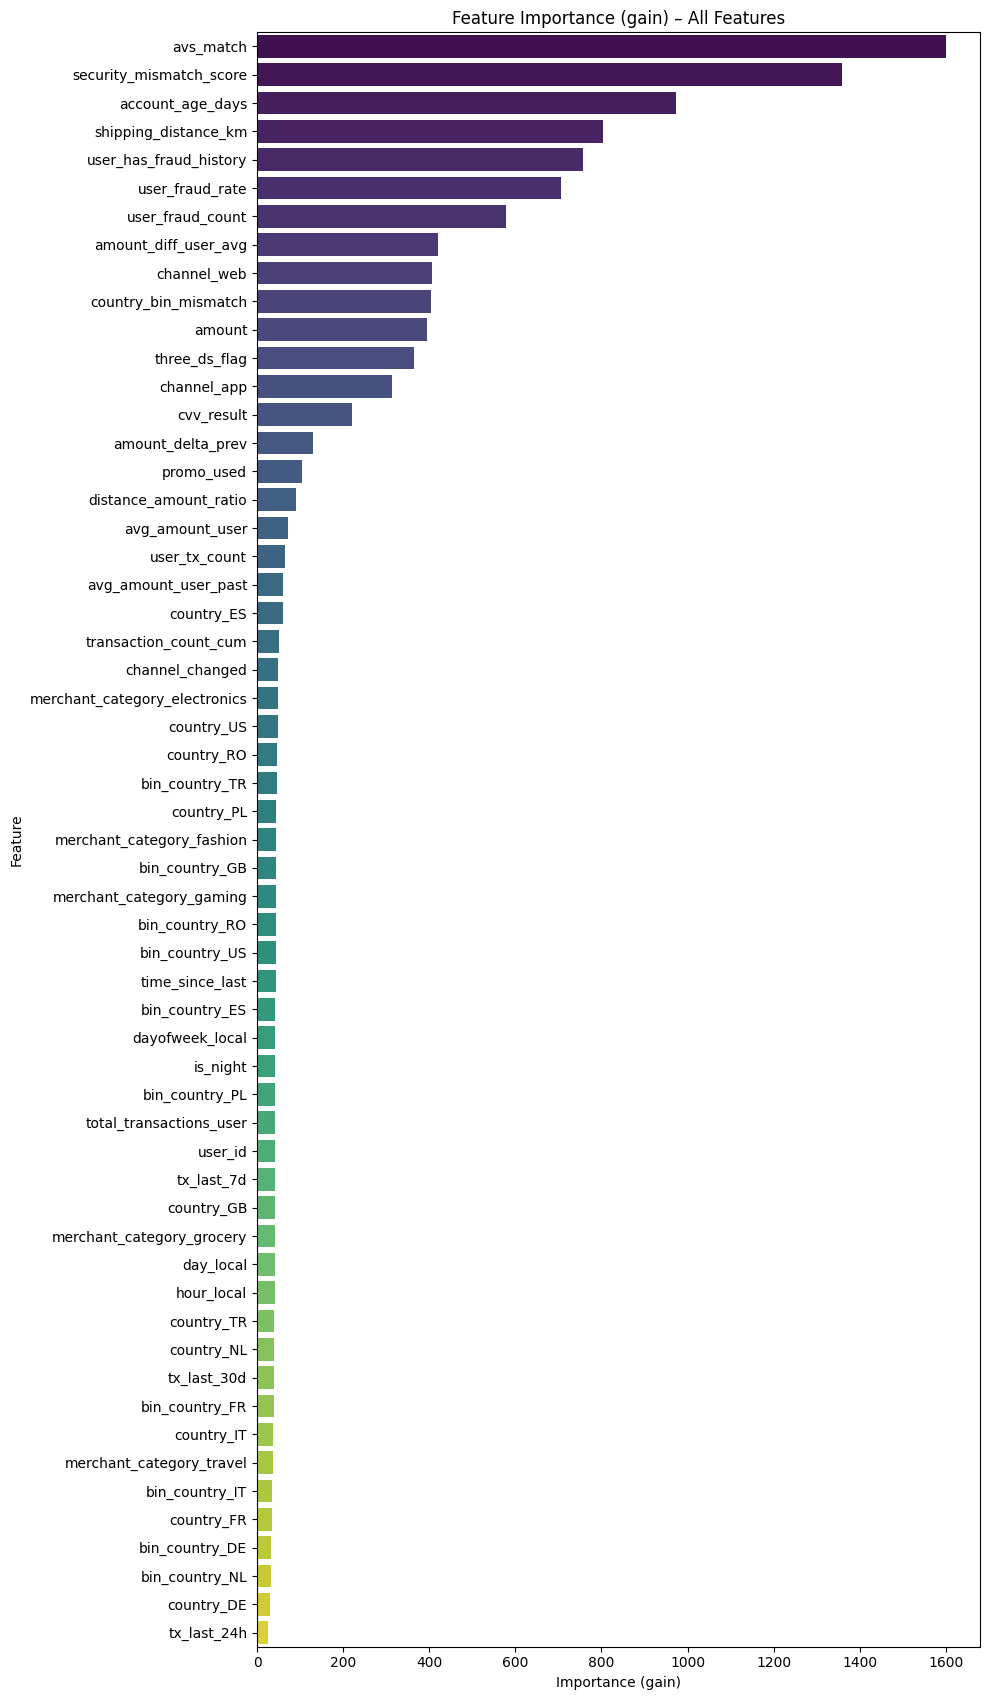

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Récupération des importances XGBoost
importance = model.get_booster().get_score(importance_type='gain')

#  DataFrame trié
importance_df = pd.DataFrame(
    importance.items(),
    columns=["feature", "importance"]
).sort_values("importance", ascending=False)

#  Affichage du tableau complet
display(importance_df)

#  Plot propre sans warning
plt.figure(figsize=(10, len(importance_df) * 0.3))  # hauteur auto-adaptée
sns.barplot(
    data=importance_df,
    x="importance",
    y="feature",
    hue="feature",        # pour éviter le warning
    dodge=False,
    legend=False,
    palette="viridis"
)
plt.title("Feature Importance (gain) – All Features")
plt.xlabel("Importance (gain)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


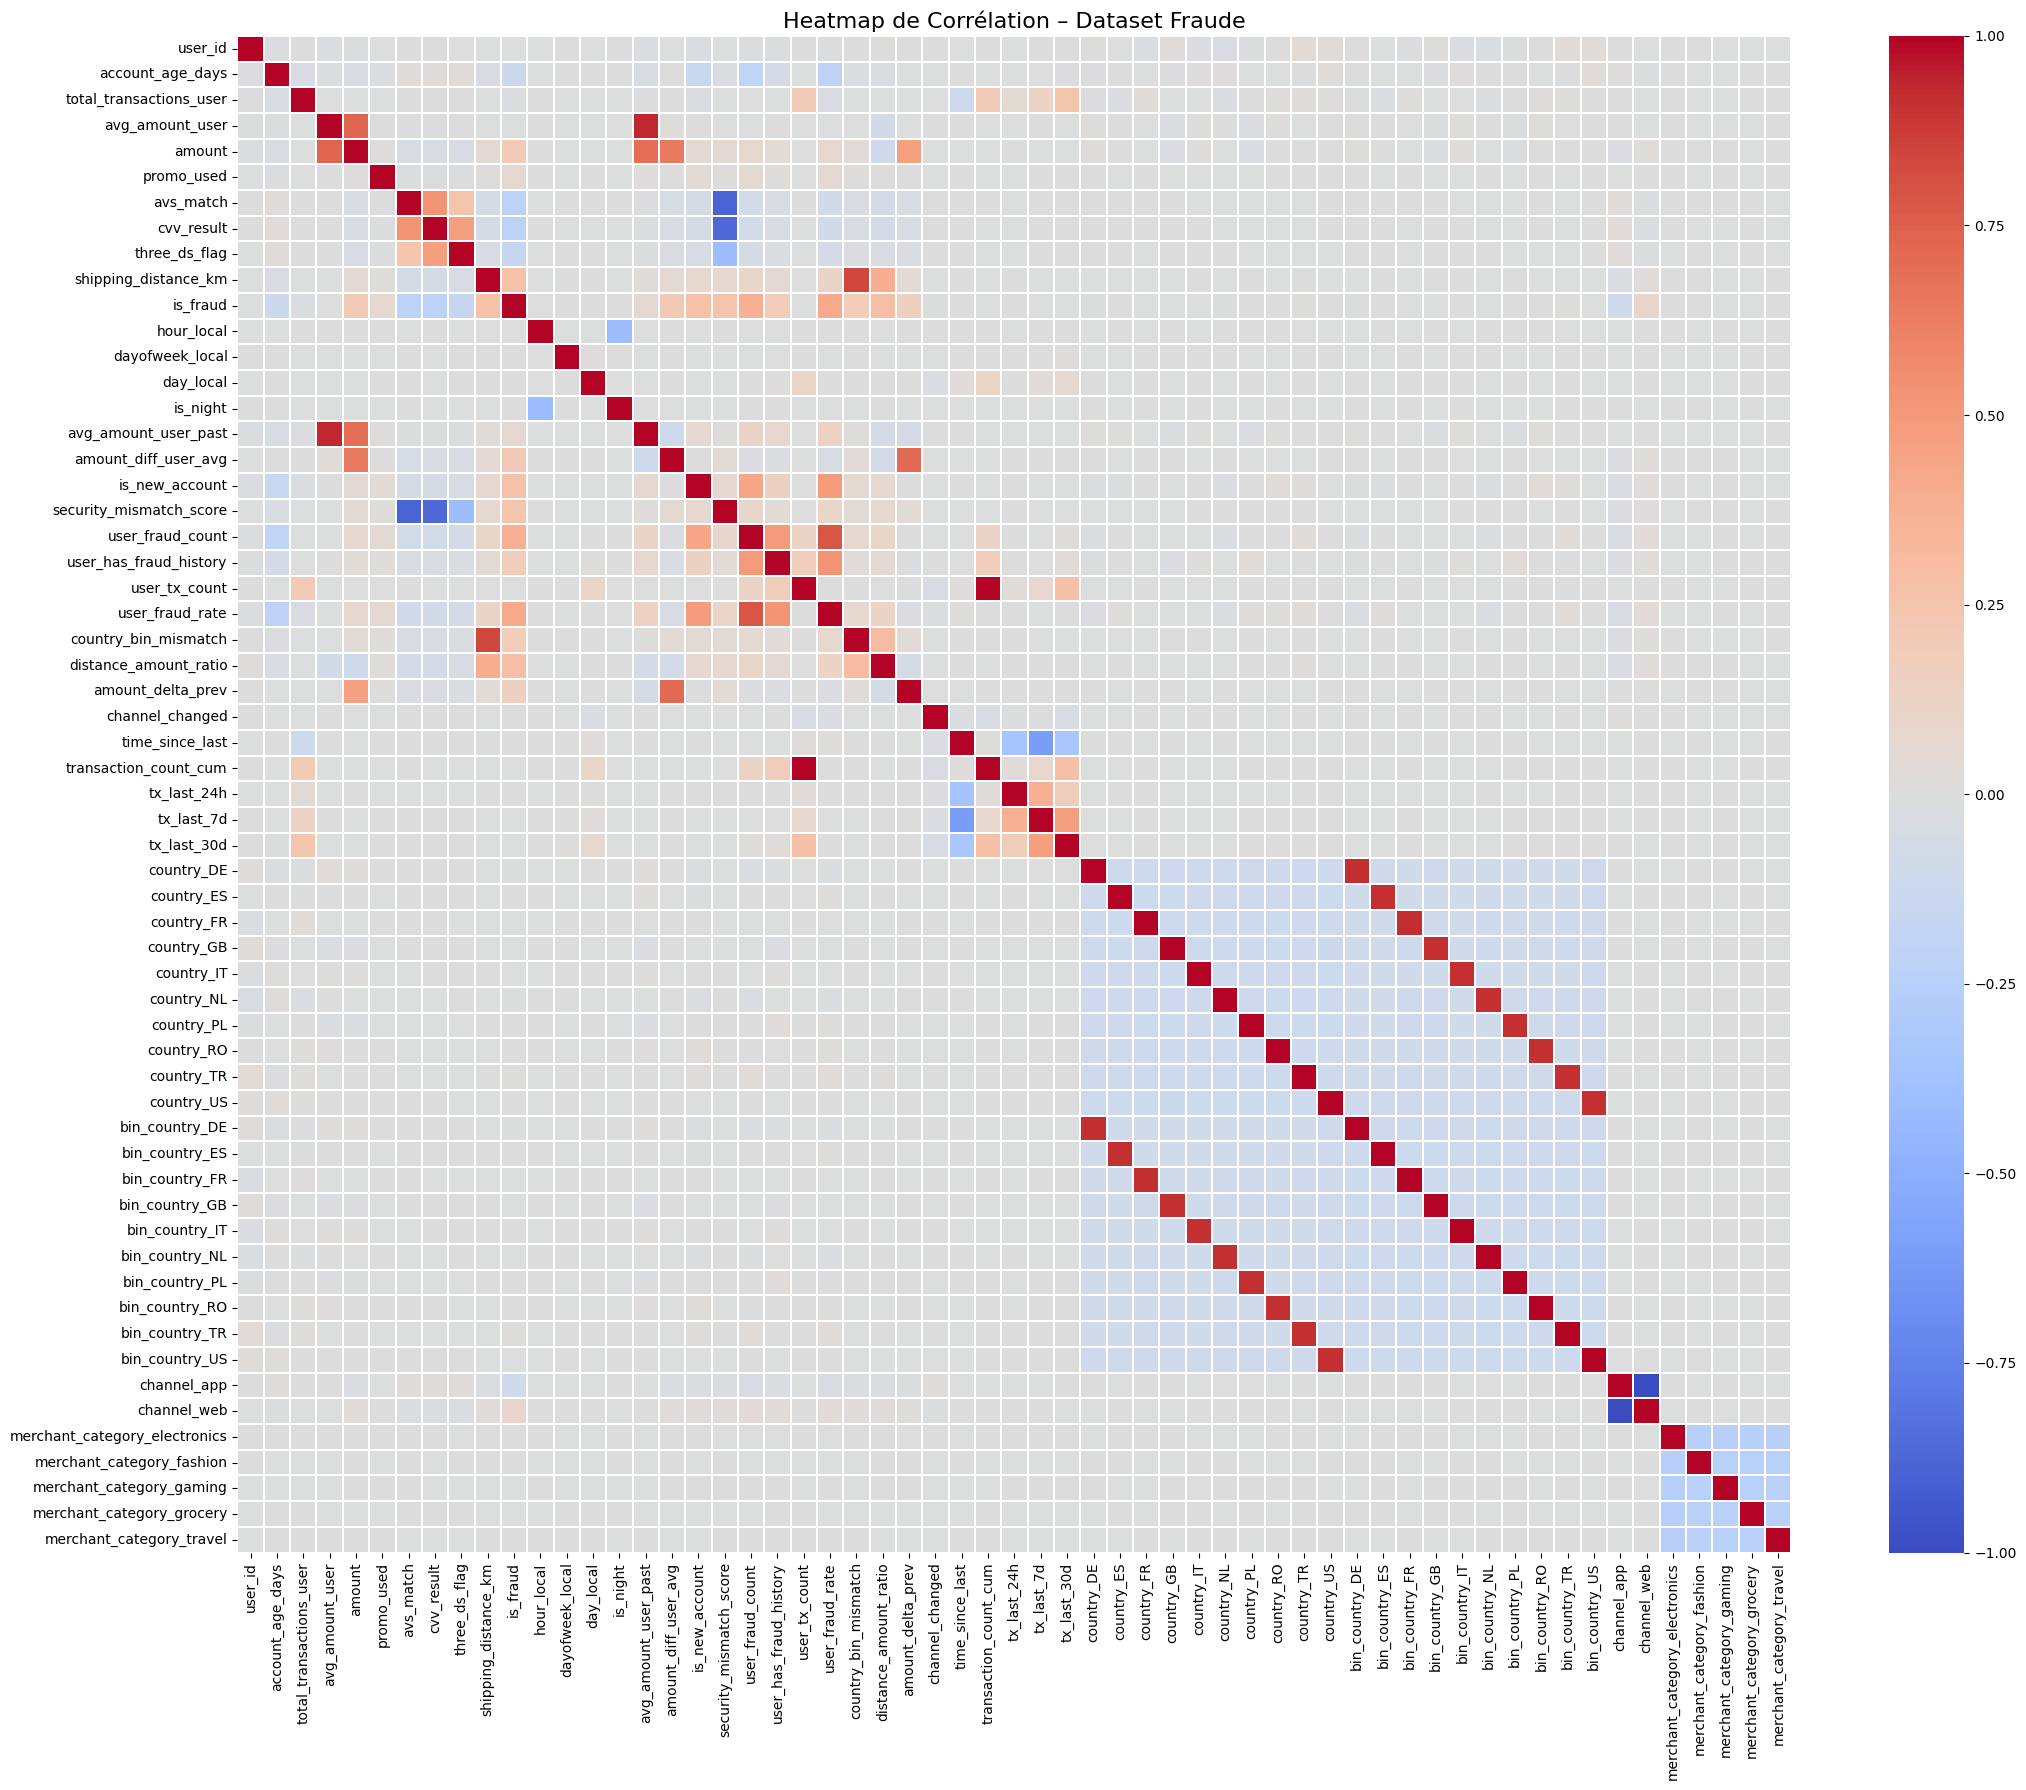

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Conversion des booléens en int (sinon heatmap plante)
df_corr = df.copy()
bool_cols = df_corr.select_dtypes(include=['bool']).columns
df_corr[bool_cols] = df_corr[bool_cols].astype(int)

# 2. Calcul des corrélations
corr_matrix = df_corr.corr()

# 3. Heatmap
plt.figure(figsize=(22, 18))
sns.heatmap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    vmin=-1, vmax=1,
    linewidths=0.1
)

plt.title("Heatmap de Corrélation – Dataset Fraude", fontsize=16)
plt.tight_layout()
plt.show()


C:\Users\khouf\AppData\Local\Temp\ipykernel_23048\1940591470.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_corr_top.values, y=target_corr_top.index, palette="coolwarm")


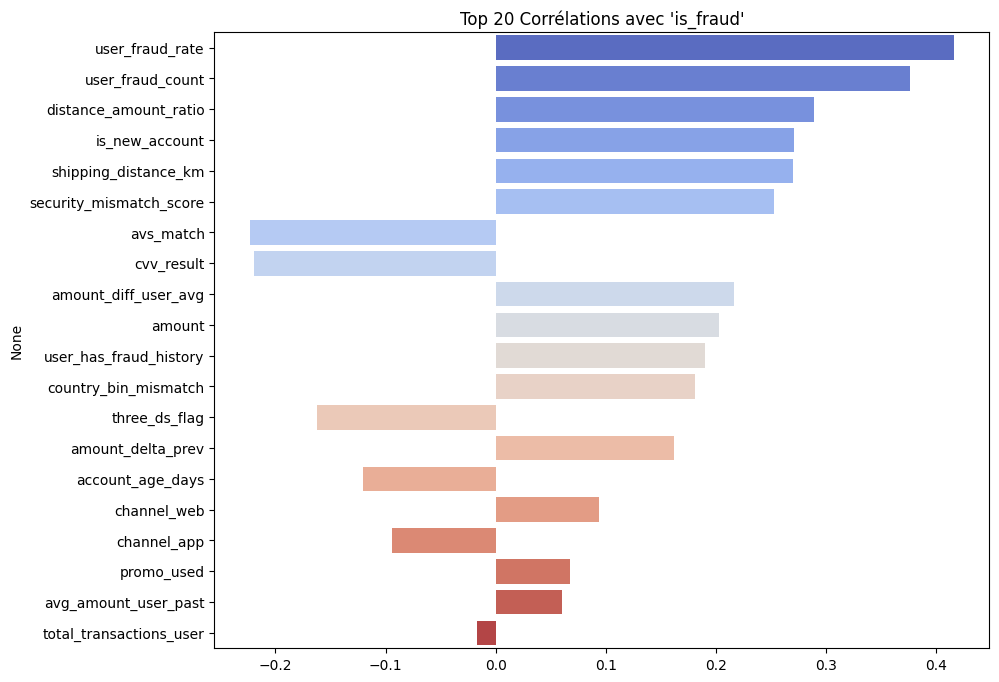

In [32]:
# 1. Obtenir les corrélations avec la variable cible
target_corr = corr_matrix['is_fraud'].drop('is_fraud')

# 2. Trier par valeur absolue et ne garder que les 20 premières
top_features = target_corr.abs().sort_values(ascending=False).head(20).index
target_corr_top = target_corr.loc[top_features]

# 3. Visualisation (Bar Plot au lieu de Heatmap)
plt.figure(figsize=(10, 8))
sns.barplot(x=target_corr_top.values, y=target_corr_top.index, palette="coolwarm")
plt.title("Top 20 Corrélations avec 'is_fraud'")
plt.show()

Typologies de fraude : antécédents, géographiques, montants, autres facteurs (canal web, promo)

<Figure size 2200x1800 with 0 Axes>

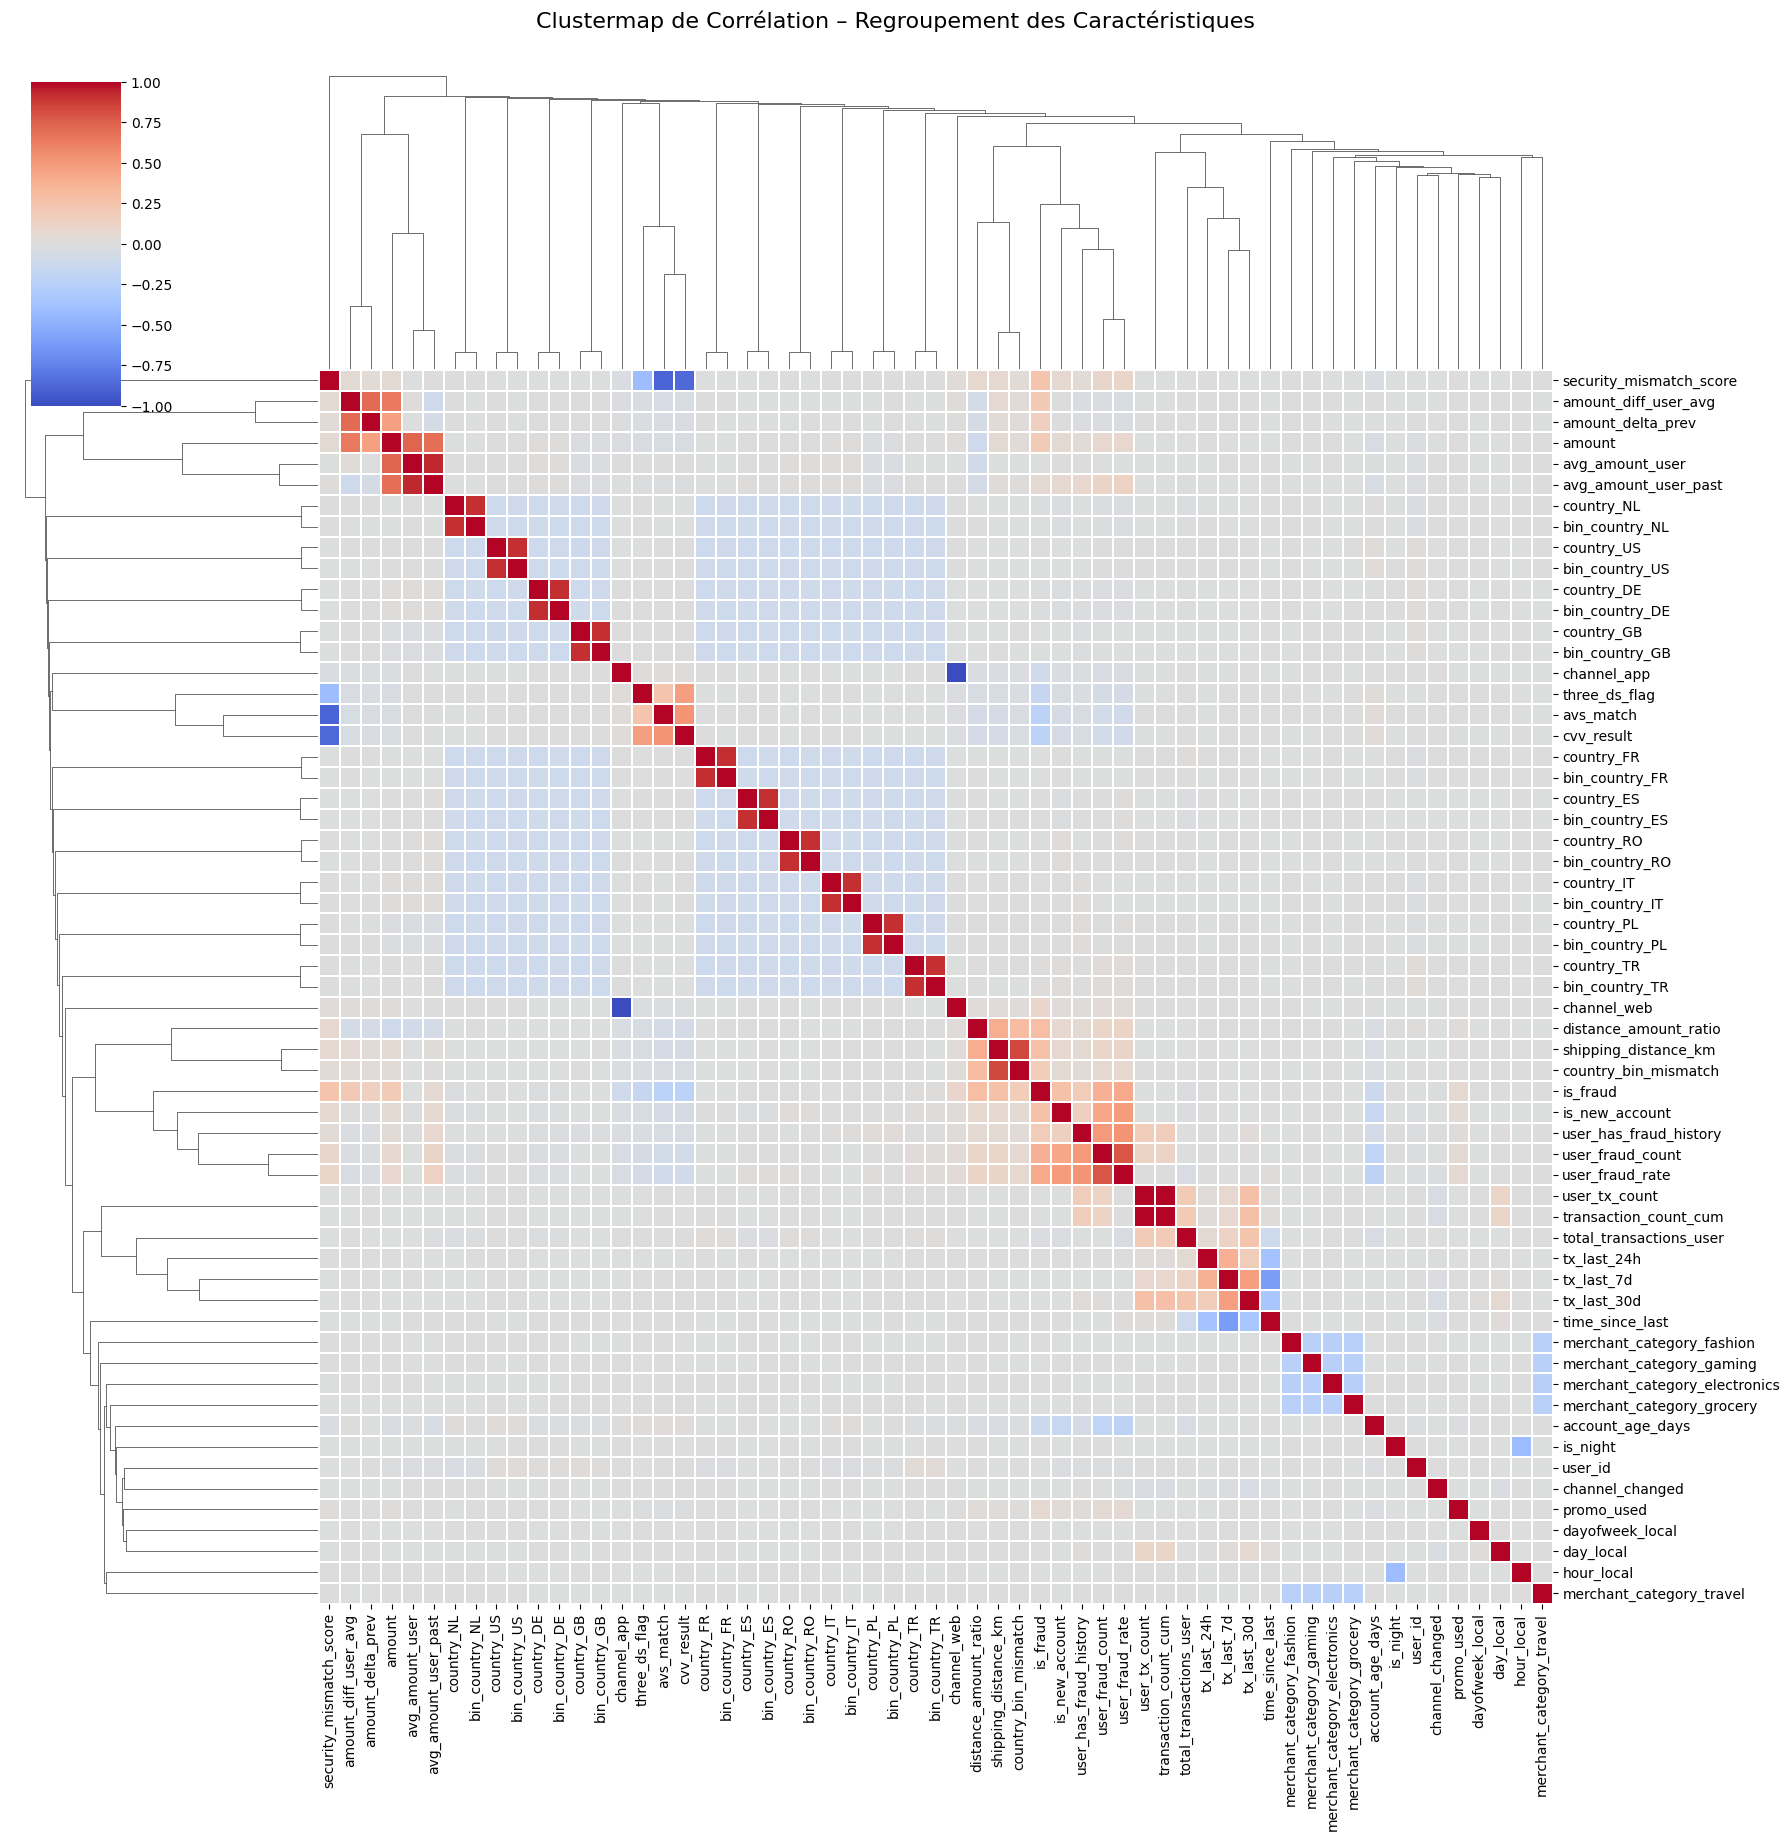

In [33]:
# 1. Utiliser clustermap au lieu de heatmap
plt.figure(figsize=(22, 18))
sns.clustermap(
    corr_matrix,
    cmap="coolwarm",
    annot=False,
    vmin=-1, vmax=1,
    linewidths=0.1,
    figsize=(18, 18) # Utiliser figsize dans clustermap lui-même
)
plt.suptitle("Clustermap de Corrélation – Regroupement des Caractéristiques", y=1.02, fontsize=16)
plt.show()

In [35]:
!pip install optuna

  Using cached optuna-4.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.17.2-py3-none-any.whl.metadata (7.2 kB)
  Using cached colorlog-6.10.1-py3-none-any.whl.metadata (11 kB)
  Using cached sqlalchemy-2.0.45-cp311-cp311-win_amd64.whl.metadata (9.8 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached pyyaml-6.0.3-cp311-cp311-win_amd64.whl.metadata (2.4 kB)
  Using cached mako-1.3.10-py3-none-any.whl.metadata (2.9 kB)
  Using cached greenlet-3.3.0-cp311-cp311-win_amd64.whl.metadata (4.2 kB)
  Using cached markupsafe-3.0.3-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
Using cached optuna-4.6.0-py3-none-any.whl (404 kB)
Using cached alembic-1.17.2-py3-none-any.whl (248 kB)
Using cached sqlalchemy-2.0.45-cp311-cp311-win_amd64.whl (2.1 MB)
Using cached greenlet-3.3.0-cp311-cp311-win_amd64.whl (301 kB)
Using cached colorlog-6.10.1-py3-none-any.whl (11 kB)
Using cached mako-1.3.10-py3-none-any.whl (78 kB)
Using cached markupsafe-3.0.3-cp311-cp311-win_a

In [36]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import train_test_split

# Fonction objectif Optuna
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1500),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 5, 50),

        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "random_state": 42,
        "n_jobs": -1
    }

    model = XGBClassifier(**params)

    # Train
    model.fit(X_train, y_train)

    # Predictions
    preds = model.predict(X_test)

    # Score orienté fraude : Recall + F1
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)

    # On maximise : trade-off F1 + Recall
    return (0.6 * recall) + (0.4 * f1)


c:\Users\khouf\anaconda3\envs\fraude-ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [37]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=150)


[I 2025-12-18 10:24:28,201] A new study created in memory with name: no-name-0fcfdce6-5ea0-4ec0-8d08-4ff102cbdbf4
[I 2025-12-18 10:24:36,999] Trial 0 finished with value: 0.8120198068953727 and parameters: {'n_estimators': 288, 'max_depth': 10, 'learning_rate': 0.26224407156181695, 'gamma': 6.645437278587824, 'min_child_weight': 6, 'subsample': 0.7166700027604305, 'colsample_bytree': 0.8506392139236789, 'scale_pos_weight': 20.7052659370055}. Best is trial 0 with value: 0.8120198068953727.
[I 2025-12-18 10:24:47,640] Trial 1 finished with value: 0.8030376883556545 and parameters: {'n_estimators': 350, 'max_depth': 10, 'learning_rate': 0.23714103587104282, 'gamma': 1.6490710572444955, 'min_child_weight': 2, 'subsample': 0.5496795807155219, 'colsample_bytree': 0.8871349497007558, 'scale_pos_weight': 30.396976591307244}. Best is trial 0 with value: 0.8120198068953727.
[I 2025-12-18 10:25:15,568] Trial 2 finished with value: 0.8080146972882121 and parameters: {'n_estimators': 1269, 'max_dep

In [38]:
print("Best Score:", study.best_value)
print("Best Params:", study.best_params)


Best Score: 0.8259773937265492
Best Params: {'n_estimators': 503, 'max_depth': 4, 'learning_rate': 0.09501027570710868, 'gamma': 8.952390786246093, 'min_child_weight': 11, 'subsample': 0.9734485348440471, 'colsample_bytree': 0.6771347179570868, 'scale_pos_weight': 7.1671330912297675}


In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# ===============================
# 1. Modèle XGBoost – Best Optuna Params
# ===============================

model = XGBClassifier(
    n_estimators=360,
    max_depth=3,
    learning_rate=0.08988925976027803,
    gamma=6.832453848633769,
    min_child_weight=16,
    subsample=0.9989920858950934,
    colsample_bytree=0.5418940975093512,
    scale_pos_weight=5.003569800495007,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# ===============================
# 2. Entraînement
# ===============================
model.fit(X_train, y_train)

# ===============================
# 3. Prédictions (seuil par défaut 0.5)
# ===============================
y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

# ===============================
# 4. Scores
# ===============================
print("===== TRAIN RESULTS =====")
print("Recall   :", recall_score(y_train, y_train_pred))
print("Precision:", precision_score(y_train, y_train_pred))
print("F1-score :", f1_score(y_train, y_train_pred))

print("\n===== TEST RESULTS =====")
print("Recall   :", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1-score :", f1_score(y_test, y_test_pred))

# ===============================
# 5. Confusion Matrix
# ===============================
print("\n===== CONFUSION MATRIX =====")
print(confusion_matrix(y_test, y_test_pred))

print("\n===== CLASSIFICATION REPORT =====")
print(classification_report(y_test, y_test_pred))



===== TRAIN RESULTS =====
Recall   : 0.8283553875236295
Precision: 0.8067010309278351
F1-score : 0.8173848162656221

===== TEST RESULTS =====
Recall   : 0.8335854765506808
Precision: 0.8037928519328957
F1-score : 0.818418121054586

===== CONFUSION MATRIX =====
[[58348   269]
 [  220  1102]]

===== CLASSIFICATION REPORT =====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     58617
           1       0.80      0.83      0.82      1322

    accuracy                           0.99     59939
   macro avg       0.90      0.91      0.91     59939
weighted avg       0.99      0.99      0.99     59939



In [40]:
!pip install catboost

  Using cached catboost-1.2.8-cp311-cp311-win_amd64.whl.metadata (1.5 kB)
  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.14.0-py3-none-any.whl.metadata (13 kB)
Using cached catboost-1.2.8-cp311-cp311-win_amd64.whl (102.5 MB)
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
Using cached plotly-6.5.0-py3-none-any.whl (9.9 MB)
Using cached narwhals-2.14.0-py3-none-any.whl (430 kB)

   ---------------------------------------- 0/4 [narwhals]
   ---------------------------------------- 0/4 [narwhals]
   ---------------------------------------- 0/4 [narwhals]
   ---------- ----------------------------- 1/4 [graphviz]
   -------------------- ------------------- 2/4 [plotly]
   -------------------- ------------------- 2/4 [plotly]
   -------------------- ------------------- 2/4 [plotly]
   -------------------- ------------------- 2/4 [plotly]
   -------------------- ------------------- 2/

In [41]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import recall_score, precision_score, f1_score
import pandas as pd


models = {
    "XGBoost": XGBClassifier(
        n_estimators=360,
        max_depth=3,
        learning_rate=0.08988925976027803,
        gamma=6.832453848633769,
        min_child_weight=16,
        subsample=0.9989920858950934,
        colsample_bytree=0.5418940975093512,
        scale_pos_weight=5.003569800495007,
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1
    ),

    "RandomForest": RandomForestClassifier(
        n_estimators=300,
        max_depth=12,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),

    "ExtraTrees": ExtraTreesClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    ),

    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_depth=10,
        learning_rate=0.1,
        l2_regularization=1.0,
        random_state=42
    ),

    "CatBoost": CatBoostClassifier(
        iterations=400,
        depth=6,
        learning_rate=0.05,
        loss_function="Logloss",
        verbose=0,
        random_state=42
    )
}

results = []

def evaluate_model(name, model):
    preds = model.predict(X_test)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append([name, recall, precision, f1])


print("=== TRAINING MODELS ===")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    evaluate_model(name, model)

results_df = pd.DataFrame(results, columns=["Model", "Recall", "Precision", "F1"])

print("\n=== RESULTS COMPARISON ===")
print(results_df.sort_values("F1", ascending=False))


=== TRAINING MODELS ===
Training XGBoost...
Training RandomForest...
Training ExtraTrees...


ValueError: Input X contains NaN.
ExtraTreesClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

def pipe(model):
    return Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("model", model)
    ])

models = {
    "XGBoost": XGBClassifier(
        n_estimators=360, max_depth=3, 
        learning_rate=0.08988925976027803,
        gamma=6.832453848633769, 
        min_child_weight=16,
        subsample=0.9989920858950934, 
        colsample_bytree=0.5418940975093512,
        scale_pos_weight=5.003569800495007, 
        objective="binary:logistic",
        eval_metric="logloss", 
        random_state=42, 
        n_jobs=-1
    ),  # XGBoost accepte les NaN, pipeline optionnel
    "RandomForest": pipe(RandomForestClassifier(
        n_estimators=300, 
        max_depth=12, 
        class_weight="balanced",
        random_state=42, 
        n_jobs=-1
    )),
    "ExtraTrees": pipe(ExtraTreesClassifier(
        n_estimators=300, 
        max_depth=None, 
        class_weight="balanced",
        random_state=42, 
        n_jobs=-1
    )),
    "HistGradientBoosting": HistGradientBoostingClassifier(
        max_depth=10, 
        learning_rate=0.1, 
        l2_regularization=1.0, 
        random_state=42

    ),  
    
    "CatBoost": CatBoostClassifier(
        iterations=400, 
        depth=6, 
        earning_rate=0.05,
        loss_function="Logloss", 
        verbose=0, 
        random_state=42
    )  
}


In [56]:
results = []

def evaluate_model(name, model):
    preds = model.predict(X_test)
    recall = recall_score(y_test, preds)
    precision = precision_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append([name, recall, precision, f1])


print("=== TRAINING MODELS ===")
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    evaluate_model(name, model)

results_df = pd.DataFrame(results, columns=["Model", "Recall", "Precision", "F1"])

print("\n=== RESULTS COMPARISON ===")
print(results_df.sort_values("F1", ascending=False))

=== TRAINING MODELS ===
Training XGBoost...
Training RandomForest...
Training ExtraTrees...
Training HistGradientBoosting...
Training CatBoost...

=== RESULTS COMPARISON ===
                  Model    Recall  Precision        F1
4              CatBoost  0.762481   0.941176  0.842457
3  HistGradientBoosting  0.767776   0.932048  0.841974
0               XGBoost  0.833585   0.803793  0.818418
2            ExtraTrees  0.533283   0.903846  0.670790
1          RandomForest  0.871407   0.454797  0.597665


In [43]:
!pip uninstall -y scikit-learn imbalanced-learn


Found existing installation: scikit-learn 1.4.2
Uninstalling scikit-learn-1.4.2:
  Successfully uninstalled scikit-learn-1.4.2
Found existing installation: imbalanced-learn 0.12.2
Uninstalling imbalanced-learn-0.12.2:
  Successfully uninstalled imbalanced-learn-0.12.2


You can safely remove it manually.


In [44]:
!pip install "scikit-learn==1.4.2" "imbalanced-learn==0.12.2"

  Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl.metadata (11 kB)
  Using cached imbalanced_learn-0.12.2-py3-none-any.whl.metadata (8.2 kB)
Using cached scikit_learn-1.4.2-cp311-cp311-win_amd64.whl (10.6 MB)
Using cached imbalanced_learn-0.12.2-py3-none-any.whl (257 kB)

   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------------------------- 0/2 [scikit-learn]
   ---------------------

In [45]:
# ============================================================
# SMOTETomek robuste
# Gère automatiquement les datasets :
# - full numériques
# - mixtes numériques / catégorielles
# ============================================================

import numpy as np
from sklearn.impute import SimpleImputer
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTENC, SMOTE

# ============================================================
# 1. Copies de sécurité
# ============================================================

X_train_res = X_train.copy()
y_train_res = y_train.copy()

# ============================================================
# 2. Détection des types de colonnes
# ============================================================

cat_cols = X_train_res.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X_train_res.columns.difference(cat_cols).tolist()

print("Colonnes catégorielles :", cat_cols)
print("Colonnes numériques :", num_cols)

# ============================================================
# 3. Imputation des valeurs manquantes
# ============================================================

# Numériques -> médiane
num_imputer = SimpleImputer(strategy="median")
X_train_res[num_cols] = num_imputer.fit_transform(X_train_res[num_cols])

# Catégorielles -> valeur la plus fréquente (si présentes)
if len(cat_cols) > 0:
    cat_imputer = SimpleImputer(strategy="most_frequent")
    X_train_res[cat_cols] = cat_imputer.fit_transform(X_train_res[cat_cols])

print("Nombre total de NaN restants :", X_train_res.isna().sum().sum())

# ============================================================
# 4. Sélection automatique de la stratégie SMOTE
# ============================================================

if len(cat_cols) > 0:
    # Cas colonnes catégorielles non encodées
    cat_indices = [X_train_res.columns.get_loc(col) for col in cat_cols]
    print("Stratégie : SMOTENC + TomekLinks")

    smote = SMOTENC(
        categorical_features=cat_indices,
        random_state=42,
        k_neighbors=5
    )
else:
    # Cas full numérique
    print("Stratégie : SMOTE classique + TomekLinks")

    smote = SMOTE(
        random_state=42,
        k_neighbors=5
    )

smote_tomek = SMOTETomek(
    smote=smote,
    random_state=42,
    n_jobs=-1
)

# ============================================================
# 5. Resampling (TRAIN uniquement)
# ============================================================

X_train_balanced, y_train_balanced = smote_tomek.fit_resample(
    X_train_res,
    y_train_res
)

# ============================================================
# 6. Résumé final
# ============================================================

print("\n================ RÉSULTAT =================")
print(
    f"Avant  : {X_train_res.shape[0]:,} lignes | "
    f"{y_train_res.sum():,} fraudes ({y_train_res.mean():.2%})"
)

print(
    f"Après  : {X_train_balanced.shape[0]:,} lignes | "
    f"{y_train_balanced.sum():,} fraudes ({y_train_balanced.mean():.2%})"
)


Colonnes catégorielles : []
Colonnes numériques : ['user_id', 'account_age_days', 'total_transactions_user', 'avg_amount_user', 'amount', 'promo_used', 'avs_match', 'cvv_result', 'three_ds_flag', 'shipping_distance_km', 'hour_local', 'dayofweek_local', 'day_local', 'is_night', 'avg_amount_user_past', 'amount_diff_user_avg', 'is_new_account', 'security_mismatch_score', 'user_fraud_count', 'user_has_fraud_history', 'user_tx_count', 'user_fraud_rate', 'country_bin_mismatch', 'distance_amount_ratio', 'amount_delta_prev', 'channel_changed', 'time_since_last', 'transaction_count_cum', 'tx_last_24h', 'tx_last_7d', 'tx_last_30d', 'country_DE', 'country_ES', 'country_FR', 'country_GB', 'country_IT', 'country_NL', 'country_PL', 'country_RO', 'country_TR', 'country_US', 'bin_country_DE', 'bin_country_ES', 'bin_country_FR', 'bin_country_GB', 'bin_country_IT', 'bin_country_NL', 'bin_country_PL', 'bin_country_RO', 'bin_country_TR', 'bin_country_US', 'channel_app', 'channel_web', 'merchant_category_e

Exception in thread Thread-94 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\khouf\anaconda3\envs\fraude-ml\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "c:\Users\khouf\anaconda3\envs\fraude-ml\Lib\threading.py", line 982, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\khouf\anaconda3\envs\fraude-ml\Lib\subprocess.py", line 1599, in _readerthread
    buffer.append(fh.read())
                  ^^^^^^^^^
  File "<frozen codecs>", line 322, in decode
UnicodeDecodeError: 'utf-8' codec can't decode byte 0x82 in position 110: invalid start byte



================ RÉSULTAT =================
Avant  : 239,756 lignes | 5,290 fraudes (2.21%)
Après  : 467,632 lignes | 233,816 fraudes (50.00%)


In [46]:
# ============================================================
# XGBOOST FINAL — FRAUDE DETECTION (SETUP VALIDÉ)
# ============================================================

import numpy as np
import xgboost as xgb

from sklearn.metrics import (
    roc_auc_score,
    classification_report,
    confusion_matrix
)

# ============================================================
# 1. SCALE_POS_WEIGHT (SUR TRAIN BALANCÉ)
# ============================================================

neg, pos = np.bincount(y_train_balanced)
scale_pos_weight = neg / pos

print("scale_pos_weight :", scale_pos_weight)

# ============================================================
# 2. MODÈLE XGBOOST — PARAMÈTRES OPTUNA
# ============================================================

xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",                 # adapté dataset déséquilibré
    n_estimators=360,
    max_depth=3,
    learning_rate=0.08988925976027803,
    gamma=6.832453848633769,
    min_child_weight=16,
    subsample=0.9989920858950934,
    colsample_bytree=0.5418940975093512,
    scale_pos_weight=scale_pos_weight,   # cohérent avec train rééquilibré
    tree_method="hist",
    random_state=42,
    n_jobs=-1
)

# ============================================================
# 3. ENTRAÎNEMENT (TRAIN SMOTÉ UNIQUEMENT)
# ============================================================

print("\nEntraînement XGBoost...")
xgb_model.fit(X_train_balanced, y_train_balanced)

# ============================================================
# 4. PRÉDICTIONS SUR LE TEST RÉEL (NON SMOTÉ)
# ============================================================

y_proba = xgb_model.predict_proba(X_test)[:, 1]

# ============================================================
# 5. AJUSTEMENT DU SEUIL (ORIENTÉ RECALL)
# ============================================================

threshold = 0.30
y_pred = (y_proba >= threshold).astype(int)

print("Seuil utilisé :", threshold)

# ============================================================
# 6. ÉVALUATION FINALE
# ============================================================

print("\n================ PERFORMANCE TEST =================")

print("ROC AUC :", roc_auc_score(y_test, y_proba))

print("\nConfusion Matrix :")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report :")
print(classification_report(y_test, y_pred, digits=4))




scale_pos_weight : 1.0

Entraînement XGBoost...
Seuil utilisé : 0.3

================ PERFORMANCE TEST =================
ROC AUC : 0.9808272111917469

Confusion Matrix :
[[58413   204]
 [  242  1080]]

Classification Report :
              precision    recall  f1-score   support

           0     0.9959    0.9965    0.9962     58617
           1     0.8411    0.8169    0.8289      1322

    accuracy                         0.9926     59939
   macro avg     0.9185    0.9067    0.9125     59939
weighted avg     0.9925    0.9926    0.9925     59939



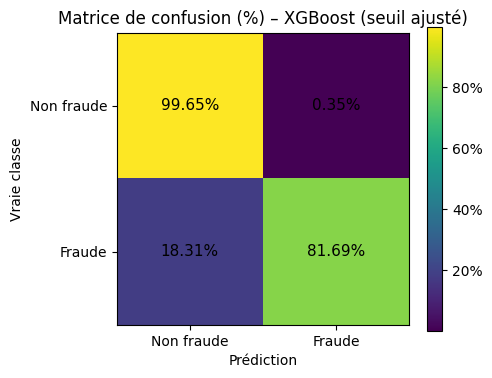

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Matrice de confusion brute
cm = confusion_matrix(y_test, y_pred)

# Normalisation par ligne (vraie classe)
cm_percent = cm.astype(float) / cm.sum(axis=1, keepdims=True) * 100

# Affichage
plt.figure(figsize=(5, 4))
plt.imshow(cm_percent)
plt.colorbar(format="%.0f%%")

plt.xticks([0, 1], ["Non fraude", "Fraude"])
plt.yticks([0, 1], ["Non fraude", "Fraude"])

plt.xlabel("Prédiction")
plt.ylabel("Vraie classe")
plt.title("Matrice de confusion (%) – XGBoost (seuil ajusté)")

# Valeurs en %
for i in range(2):
    for j in range(2):
        plt.text(
            j,
            i,
            f"{cm_percent[i, j]:.2f}%",
            ha="center",
            va="center",
            fontsize=11
        )

plt.tight_layout()
plt.show()



La matrice de confusion normalisée montre que le modèle laisse passer plus de 99,6 % des transactions légitimes tout en détectant plus de 81 % des fraudes, ce qui constitue un compromis pertinent entre risque financier et impact client.

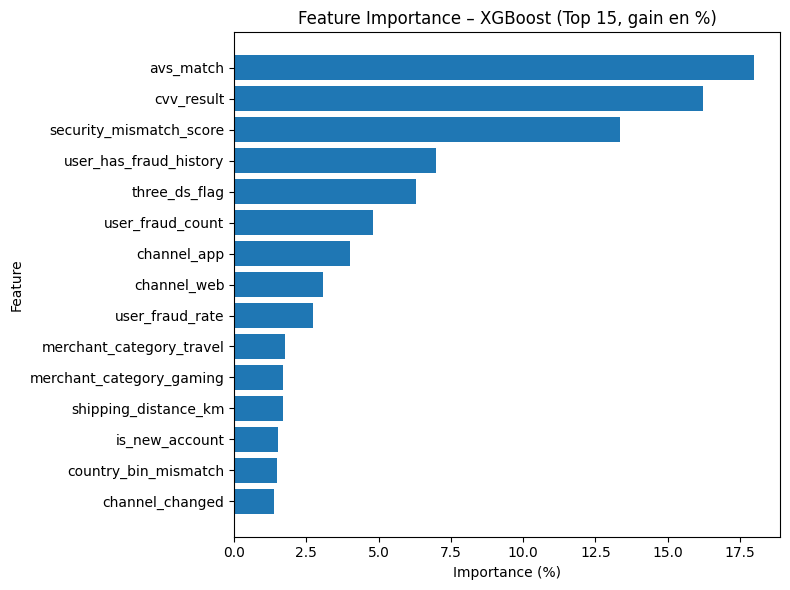

In [48]:
# Récupération des importances (gain)
importances = xgb_model.get_booster().get_score(importance_type="gain")

# DataFrame
fi_df = pd.DataFrame({
    "Feature": importances.keys(),
    "Gain": importances.values()
})

# Normalisation en %
fi_df["Importance_%"] = fi_df["Gain"] / fi_df["Gain"].sum() * 100

# Sélection du Top 15
fi_top15 = fi_df.sort_values("Importance_%", ascending=False).head(15)

# Tri pour affichage horizontal
fi_top15 = fi_top15.sort_values("Importance_%", ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(fi_top15["Feature"], fi_top15["Importance_%"])
plt.xlabel("Importance (%)")
plt.ylabel("Feature")
plt.title("Feature Importance – XGBoost (Top 15, gain en %)")
plt.tight_layout()
plt.show()



L’analyse d’importance montre que le modèle se base principalement sur des signaux de sécurité du paiement et de cohérence transactionnelle, complétés par l’historique utilisateur et le contexte, ce qui est conforme aux pratiques antifraude

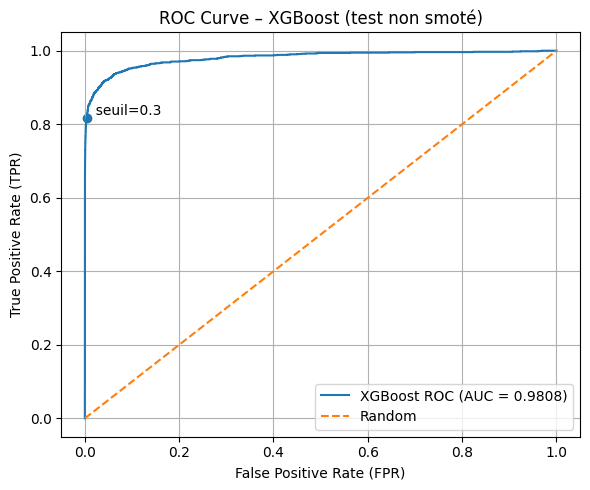

In [49]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np

# ROC + AUC
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

# Trouver le point correspondant au seuil choisi (ex: 0.30)
threshold_target = 0.30
idx = np.argmin(np.abs(thresholds - threshold_target))

# Plot
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"XGBoost ROC (AUC = {auc_score:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")

# Annotation du seuil
plt.scatter(fpr[idx], tpr[idx])
plt.text(
    fpr[idx], tpr[idx],
    f"  seuil={threshold_target}",
    verticalalignment="bottom"
)

plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve – XGBoost (test non smoté)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



La courbe ROC montre que le modèle discrimine très bien les classes avec une AUC proche de 0,98. Le seuil opérationnel n’est pas choisi sur la ROC mais en fonction du compromis métier, ici orienté recall, ce qui est matérialisé par le point à 0,3.

In [50]:
!pip install shap

  Using cached shap-0.50.0-cp311-cp311-win_amd64.whl.metadata (25 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached numba-0.63.1-cp311-cp311-win_amd64.whl.metadata (2.8 kB)
  Using cached cloudpickle-3.1.2-py3-none-any.whl.metadata (7.1 kB)
  Using cached llvmlite-0.46.0-cp311-cp311-win_amd64.whl.metadata (4.9 kB)
Using cached shap-0.50.0-cp311-cp311-win_amd64.whl (547 kB)
Using cached slicer-0.0.8-py3-none-any.whl (15 kB)
Using cached numba-0.63.1-cp311-cp311-win_amd64.whl (2.7 MB)
Using cached llvmlite-0.46.0-cp311-cp311-win_amd64.whl (38.1 MB)
Using cached cloudpickle-3.1.2-py3-none-any.whl (22 kB)

   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   -------- ------------------------------- 1/5 [llvmlite]
   ------------------------ --------------- 3/5 [numba]
   ------------------------ --------------- 3/5 [numba]
   -------

--- OBSERVATION (INDEX: 116785) ---
Vraie classe : NON FRAUDE
Données (JSON) :
{
    "user_id": 2339,
    "account_age_days": 1045,
    "total_transactions_user": 51,
    "avg_amount_user": 90.66,
    "amount": 66.28,
    "promo_used": 0,
    "avs_match": 1,
    "cvv_result": 1,
    "three_ds_flag": 1,
    "shipping_distance_km": 128.02,
    "hour_local": 16,
    "dayofweek_local": 6,
    "day_local": 21,
    "is_night": 0,
    "avg_amount_user_past": 102.73545454545454,
    "amount_diff_user_avg": -36.45545454545454,
    "is_new_account": 0,
    "security_mismatch_score": 0,
    "user_fraud_count": 0.0,
    "user_has_fraud_history": 0,
    "user_tx_count": 33,
    "user_fraud_rate": 0.0,
    "country_bin_mismatch": 0,
    "distance_amount_ratio": 1.902794292508918,
    "amount_delta_prev": 3.0900000000000034,
    "channel_changed": 1,
    "time_since_last": 57912.0,
    "transaction_count_cum": 34,
    "tx_last_24h": 1.0,
    "tx_last_7d": 2.0,
    "tx_last_30d": 5.0,
    "country_DE"

,Feature,Valeur_Feature,Impact_SHAP
0,shipping_distance_km,128.02,-1.004703
1,avs_match,1,-0.885527
2,three_ds_flag,1,-0.631397
3,dayofweek_local,6,-0.461183
4,user_fraud_rate,0.0,-0.429575
5,user_has_fraud_history,0,-0.410022
6,cvv_result,1,-0.362812
7,country_bin_mismatch,0,0.312015
8,user_fraud_count,0.0,-0.295912
9,distance_amount_ratio,1.902794,-0.294944


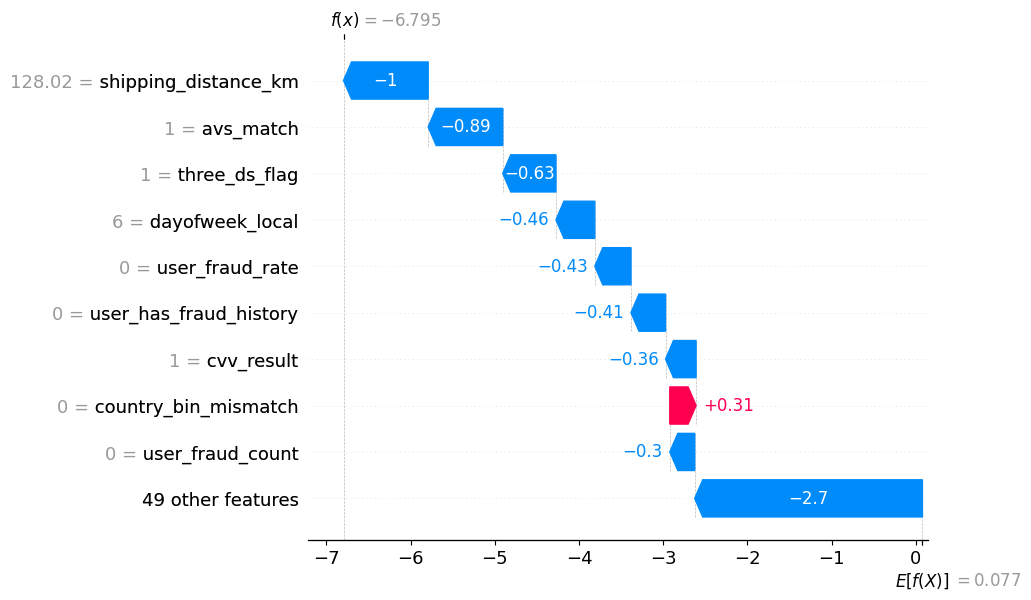

In [51]:
import json
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_random_transaction(model, X_data, y_data, threshold=0.3):
    """
    Sélectionne une transaction au hasard, prédit la fraude
    et explique la décision via SHAP, avec comparaison vérité terrain.
    """

    # ============================================================
    # 1. Sélection aléatoire d'une observation
    # ============================================================

    random_idx = np.random.choice(X_data.index)
    row_data = X_data.loc[[random_idx]]  # format DataFrame
    true_label = y_data.loc[random_idx]

    # Conversion en JSON lisible
    row_dict = row_data.iloc[0].astype(object).to_dict()
    for k, v in row_dict.items():
        if isinstance(v, (np.integer, np.floating)):
            row_dict[k] = float(v)

    json_output = json.dumps(row_dict, indent=4)

    print(f"--- OBSERVATION (INDEX: {random_idx}) ---")
    print(f"Vraie classe : {'FRAUDE' if true_label == 1 else 'NON FRAUDE'}")
    print("Données (JSON) :")
    print(json_output)
    print("-" * 60)

    # ============================================================
    # 2. Prédiction du modèle
    # ============================================================

    prob_fraud = model.predict_proba(row_data)[:, 1][0]
    pred_label = 1 if prob_fraud >= threshold else 0

    print(f"\n--- PRÉDICTION (Seuil = {threshold}) ---")
    print(f"Probabilité de fraude : {prob_fraud:.4f}")
    print(f"Classe prédite        : {'FRAUDE' if pred_label == 1 else 'NON FRAUDE'}")
    print("-" * 60)

    # ============================================================
    # 3. COMPARAISON PRÉDICTION vs RÉALITÉ (IMPORTANT)
    # ============================================================

    print("\n--- VERDICT ---")

    if pred_label == true_label:
        if pred_label == 1:
            verdict = "VRAI POSITIF (fraude correctement détectée)"
        else:
            verdict = "VRAI NÉGATIF (transaction légitime correctement classée)"
    else:
        if pred_label == 1:
            verdict = "FAUX POSITIF (transaction légitime bloquée à tort)"
        else:
            verdict = "FAUX NÉGATIF (fraude non détectée)"

    print(f"Résultat : {verdict}")
    print("-" * 60)

    # ============================================================
    # 4. EXPLICATION SHAP (locale)
    # ============================================================

    print("\n--- EXPLICATION DE LA DÉCISION (SHAP) ---")

    explainer = shap.TreeExplainer(model)
    shap_values = explainer(row_data)

    contributions = pd.DataFrame({
        "Feature": X_data.columns,
        "Valeur_Feature": row_data.iloc[0].values,
        "Impact_SHAP": shap_values.values[0]
    })

    contributions["Abs_Impact"] = contributions["Impact_SHAP"].abs()

    top_contributions = (
        contributions
        .sort_values(by="Abs_Impact", ascending=False)
        .head(10)
        .reset_index(drop=True)
    )

    print("Top 10 des facteurs ayant influencé la décision :")
    display(top_contributions[["Feature", "Valeur_Feature", "Impact_SHAP"]])

    # ============================================================
    # 5. Visualisation SHAP (Waterfall)
    # ============================================================

    plt.figure()
    shap.plots.waterfall(shap_values[0], max_display=10, show=True)


# ============================================================
# EXÉCUTION
# ============================================================

# Assure-toi que xgb_model, X_test et y_test existent
analyze_random_transaction(
    model=xgb_model,
    X_data=X_test,
    y_data=y_test,
    threshold=0.3
)


##### Beeswarm SHAP

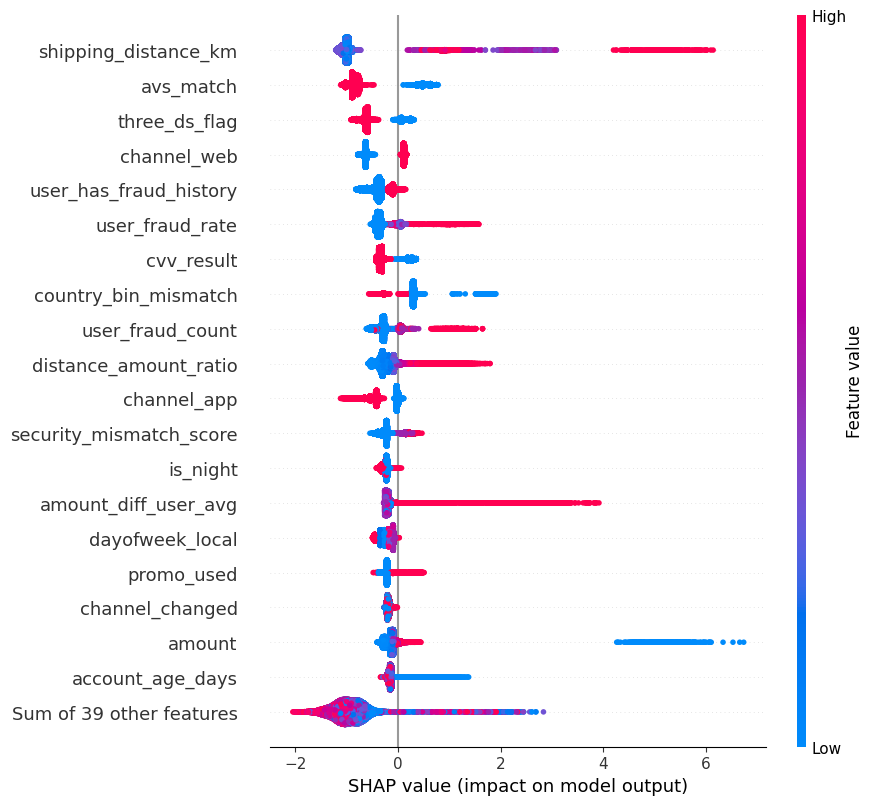

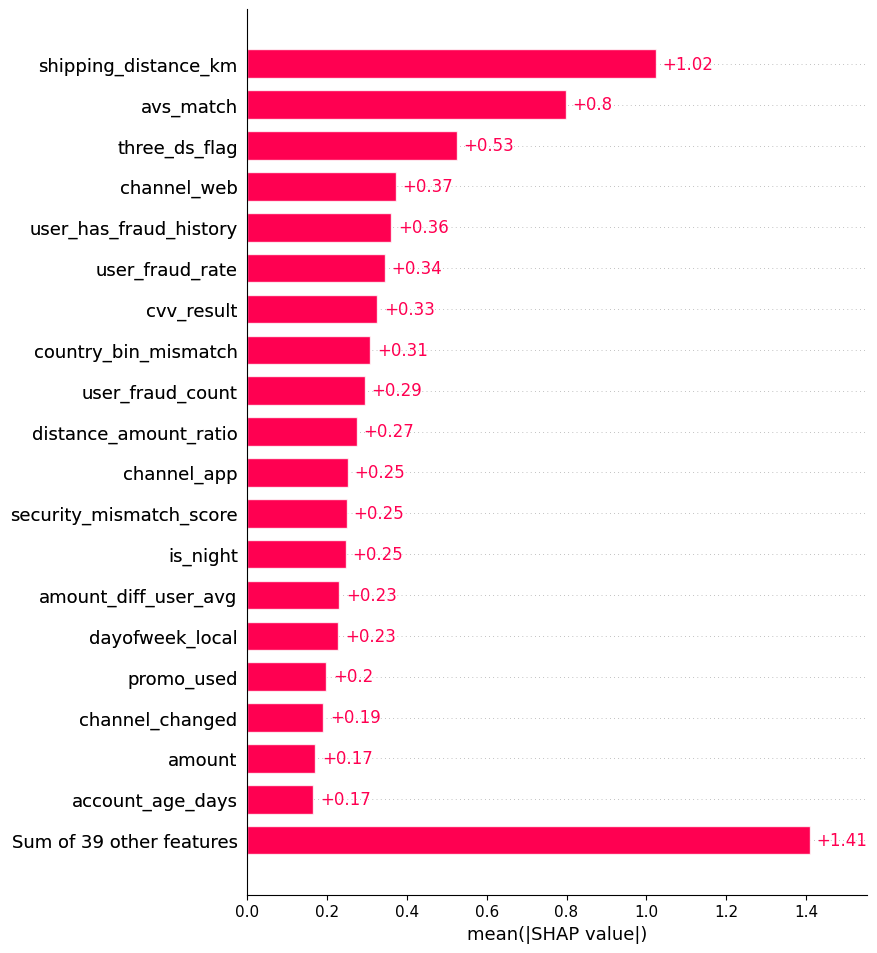

In [52]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# (optionnel) pour éviter des warnings d'affichage
shap.initjs()

# Explainer adapté aux modèles d'arbres
explainer = shap.TreeExplainer(xgb_model)

# SHAP values sur X_test complet (peut prendre du temps si X_test est gros)
shap_values = explainer(X_test)

# 1) Beeswarm : distribution + sens (droite = augmente le score de fraude)
plt.figure()
shap.plots.beeswarm(shap_values, max_display=20, show=True)

# 2) Barplot : importance globale (moyenne de |SHAP|)
plt.figure()
shap.plots.bar(shap_values, max_display=20, show=True)


#### Interprétation :
Beeswarm : 
Le beeswarm montre que le modèle combine des signaux de sécurité, d’historique utilisateur, de cohérence géographique et de comportement transactionnel. Les features issues du feature engineering sont parmi les plus discriminantes, ce qui valide les choix de construction des variables.

Barplot :
Le graphique d’importance globale montre que les variables les plus influentes sont issues du feature engineering et traduisent des règles métier antifraude. Cela confirme que l’amélioration des performances provient davantage de la qualité des features que du modèle seul.

##### conculusion : 
Les graphiques SHAP montrent que le modèle ne détecte pas la fraude sur un critère unique, mais sur la combinaison de signaux de sécurité, de comportement utilisateur, de cohérence géographique et de temporalité. Le feature engineering joue un rôle central, car ce sont majoritairement des variables construites qui guident les décisions du modèle.

In [53]:
# Calcul importance globale par mean(|SHAP|)
abs_mean = np.abs(shap_values.values).mean(axis=0)
feat_importance = pd.DataFrame({
    "feature": X_test.columns,
    "mean_abs_shap": abs_mean
}).sort_values("mean_abs_shap", ascending=False)

top20 = feat_importance.head(20)
print(top20)

                    feature  mean_abs_shap
9      shipping_distance_km       1.023155
6                 avs_match       0.798100
8             three_ds_flag       0.525453
52              channel_web       0.371902
19   user_has_fraud_history       0.360635
21          user_fraud_rate       0.343898
7                cvv_result       0.326149
22     country_bin_mismatch       0.308255
18         user_fraud_count       0.293993
23    distance_amount_ratio       0.273922
51              channel_app       0.252154
17  security_mismatch_score       0.249863
13                 is_night       0.246810
15     amount_diff_user_avg       0.230959
11          dayofweek_local       0.227821
5                promo_used       0.197845
25          channel_changed       0.190050
4                    amount       0.170337
1          account_age_days       0.165719
20            user_tx_count       0.137917


<Figure size 640x480 with 0 Axes>

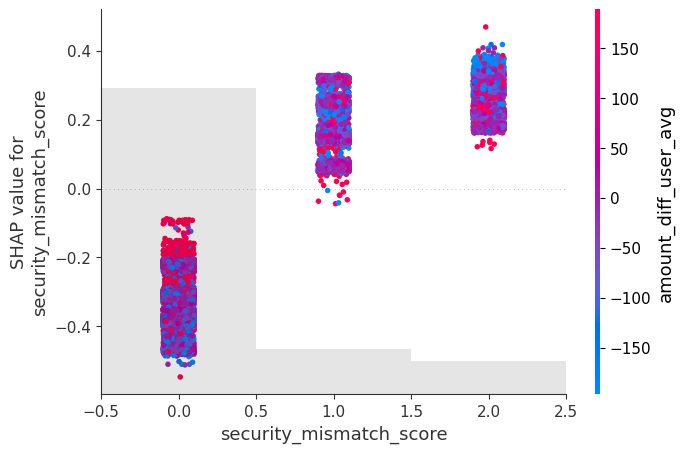

<Figure size 640x480 with 0 Axes>

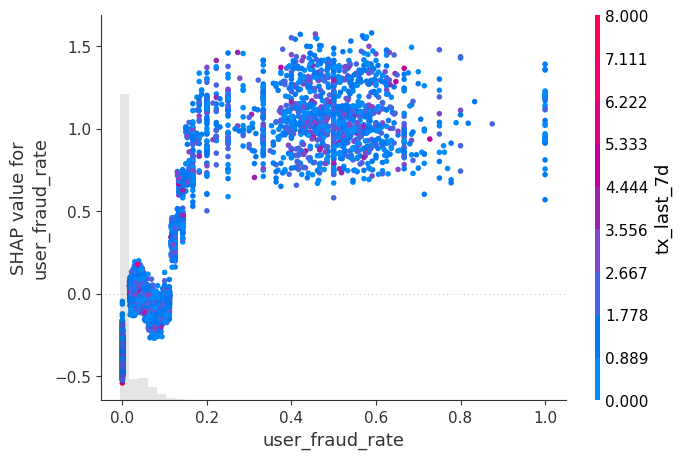

c:\Users\khouf\anaconda3\envs\fraude-ml\Lib\site-packages\shap\plots\_scatter.py:452: RuntimeWarning: invalid value encountered in greater
  min_dist = np.min(diffs[diffs > 1e-8])


<Figure size 640x480 with 0 Axes>

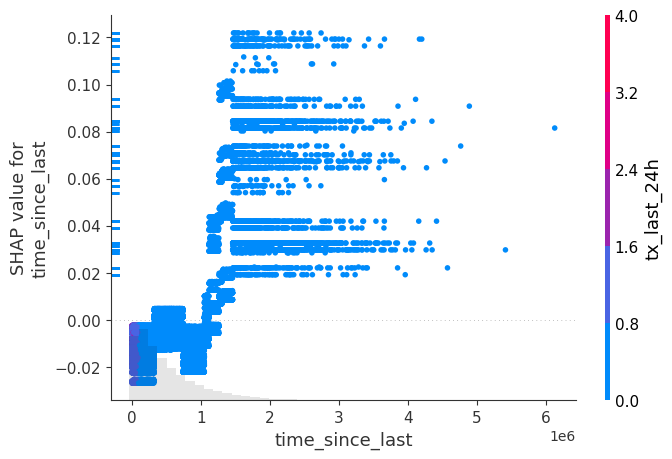

<Figure size 640x480 with 0 Axes>

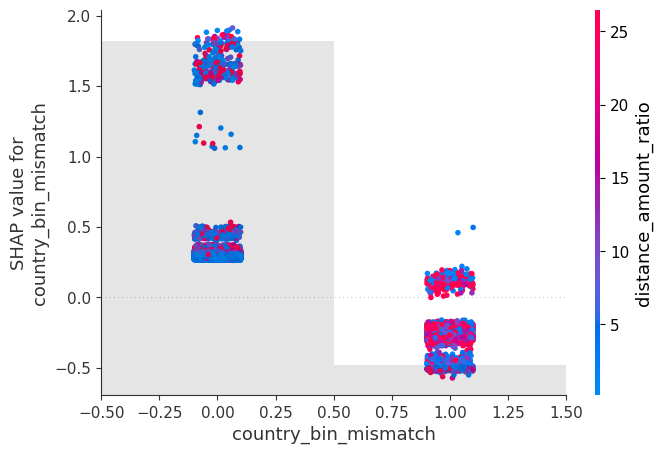

<Figure size 640x480 with 0 Axes>

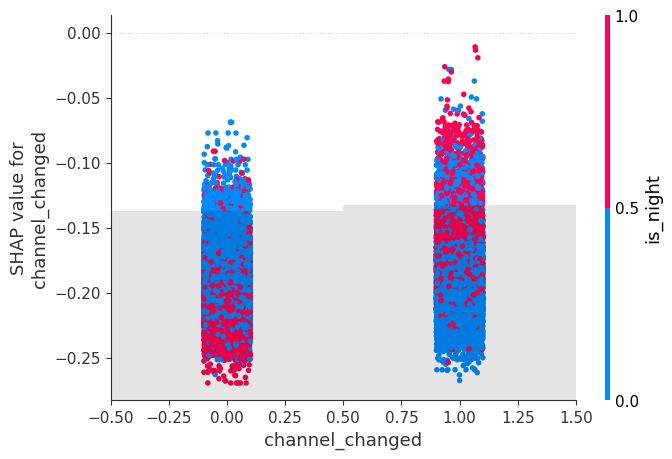

In [54]:
# Choisis 4-6 couples "métier" (tu peux ajuster les noms selon tes top20)
pairs = [
    ("security_mismatch_score", "amount_diff_user_avg"),
    ("user_fraud_rate", "tx_last_7d"),
    ("time_since_last", "tx_last_24h"),
    ("country_bin_mismatch", "distance_amount_ratio"),
    ("channel_changed", "is_night"),
]

for main_feat, color_feat in pairs:
    if main_feat in X_test.columns and color_feat in X_test.columns:
        plt.figure()
        shap.plots.scatter(
            shap_values[:, main_feat],
            color=shap_values[:, color_feat],
            show=True
        )


#### Interprétation : 
Graphe 1 : 

Un échec de sécurité augmente fortement le risque de fraude, et cet effet est amplifié lorsque le montant de la transaction est anormal par rapport au comportement habituel de l’utilisateur.

Graphe 2 : 

Le modèle apprend un effet de récidive : un utilisateur ayant déjà fraudé devient beaucoup plus suspect, surtout s’il est très actif sur une courte période.

Graphe 3 : 

Les comportements rapides et répétitifs sont fortement associés à la fraude, ce qui correspond à des comportements automatisés.

Graphe 4 : 

Une incohérence géographique devient particulièrement suspecte lorsque la distance de livraison n’est pas cohérente avec le montant de la transaction.

Graphe 5 : 

Un changement de canal, surtout lorsqu’il a lieu la nuit, est interprété par le modèle comme un comportement inhabituel et donc plus risqué.

 #### Conclusion : 

Les dependence plots SHAP montrent que le modèle ne repose jamais sur une seule variable, mais sur la combinaison de signaux de sécurité, d’historique utilisateur, de comportement temporel et de cohérence transactionnelle. Ces interactions confirment que le feature engineering permet de traduire des règles métier antifraude en signaux exploitables par le modèle.


In [55]:
# Attention : coûteux sur gros X_test
interaction_vals = explainer.shap_interaction_values(X_test)

# importance d'interaction globale : somme moyenne des |interactions|
# (hors diagonale si tu veux seulement les interactions)
inter = np.abs(interaction_vals).mean(axis=0)
inter_df = pd.DataFrame(inter, index=X_test.columns, columns=X_test.columns)

# Top interactions (hors diagonale)
mask = np.triu(np.ones_like(inter_df, dtype=bool), k=1)
top_pairs = (
    inter_df.where(mask)
    .stack()
    .sort_values(ascending=False)
    .head(10)
)
print(top_pairs)


shipping_distance_km     country_bin_mismatch      0.271202
channel_app              channel_web               0.082323
avs_match                three_ds_flag             0.069542
user_fraud_count         user_fraud_rate           0.058683
avs_match                user_fraud_count          0.056451
security_mismatch_score  user_has_fraud_history    0.054523
account_age_days         user_fraud_count          0.042532
avs_match                channel_app               0.037768
user_fraud_count         user_has_fraud_history    0.036915
security_mismatch_score  user_fraud_count          0.035295
dtype: float32
